In [ ]:
import io
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from matplotlib import image as mpimg
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from sklearn.metrics import confusion_matrix , classification_report, ConfusionMatrixDisplay
import seaborn
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
drive.mount('/content/drive')
import random

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_dir = '/content/drive/MyDrive/project'
labels_array = os.listdir(dataset_dir)
labels_array

['Apple healthy',
 'Apple Apple scab',
 'Apple Cedar apple rust',
 'Apple Black rot']

In [ ]:
for label in labels_array:
    print(label, len(os.listdir(dataset_dir+'/'+label)))

Apple healthy 3970
Apple Apple scab 6048
Apple Cedar apple rust 2666
Apple Black rot 5964


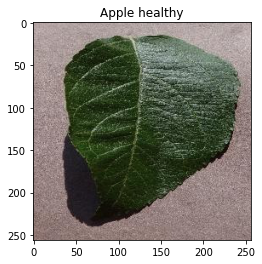

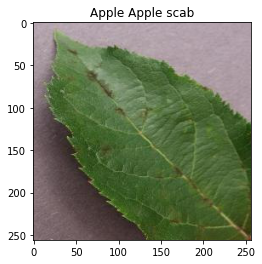

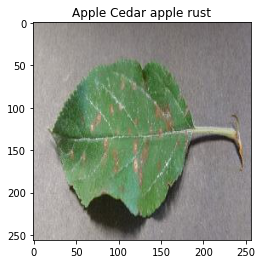

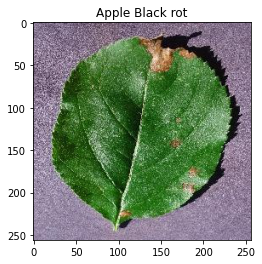

In [ ]:
x = random.randint(0, 10)
for label in labels_array:
    path = os.listdir(dataset_dir + '/' + label)
    img = dataset_dir + '/' + label + '/' + path[x]
    plt.title(label)
    image = mpimg.imread(img)
    plt.imshow(image)
    plt.show()

In [ ]:
datagen = ImageDataGenerator(
        samplewise_center=True,  # set each sample mean to 0
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,
        rescale=1./255,#scale images
        validation_split=0.2) #split data

#create training set from folders
train_data=datagen.flow_from_directory(dataset_dir,
                                       target_size=(64,64),
                                       batch_size=32,
                                       class_mode='categorical',
                                       shuffle=True,subset='training')

#create test set
test_data=datagen.flow_from_directory(dataset_dir,
                                       target_size=(64,64),
                                       batch_size=1,
                                       shuffle=False,subset='validation')

Found 14920 images belonging to 4 classes.
Found 3728 images belonging to 4 classes.


Found 18648 images belonging to 4 classes.


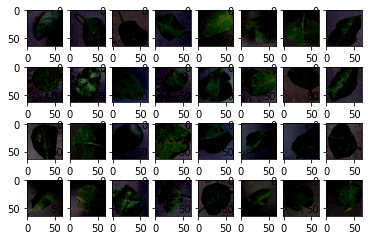

In [ ]:
import numpy as np
img_iter = datagen.flow_from_directory(dataset_dir,target_size=(64,64),batch_size=32)#pass on each picture , operate datagen in code block above which does image augmentation
x, y = img_iter.next()
fig, ax = plt.subplots(nrows=4, ncols=8)
for i in range(32):
    image = x[i]
    ax.flatten()[i].imshow(np.squeeze(image))
plt.show() 


model formulation

In [ ]:
def fnc1():
  model = Sequential([
      Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", input_shape=(64,64, 3)),
      BatchNormalization(),
      MaxPool2D((2, 2), strides=2, padding="same"),
      Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"),
      Dropout(0.2),
      BatchNormalization(),
      MaxPool2D((2, 2), strides=2, padding="same"),
      Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"),
      BatchNormalization(),
      MaxPool2D((2, 2), strides=2, padding="same"),
      Flatten(),
      Dense(units=512, activation="relu"),
      Dropout(0.3),
      Dense(units=4, activation="softmax"),
  ])
  # model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", input_shape=(64,64, 3)))
  # model.add(BatchNormalization())
  # model.add(MaxPool2D((2, 2), strides=2, padding="same"))
  # model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
  # model.add(Dropout(0.2))
  # model.add(BatchNormalization())
  # model.add(MaxPool2D((2, 2), strides=2, padding="same"))
  # model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
  # model.add(BatchNormalization())
  # model.add(MaxPool2D((2, 2), strides=2, padding="same"))
  # model.add(Flatten())
  # model.add(Dense(units=512, activation="relu"))
  # model.add(Dropout(0.3))
  # model.add(Dense(units=4, activation="softmax"))
  model.summary()
  return model

       

prepare data in arrays for model, cross validation

In [ ]:
train_x =[]
test_x = []
train_y = [] 
test_y = []
for i in range(train_data.__len__()):
  x,y=train_data.next()
  train_x.extend(x)
  train_y.extend(y)
for i in range(test_data.__len__()):
  x,y=test_data.next()
  test_x.extend(x)
  test_y.extend(y)
data=np.concatenate((train_x,test_x))
targets=np.concatenate((train_y,test_y))

cross validation

In [ ]:
from sklearn.model_selection import KFold
number_folds=2#changable (number of data divided into )
kfold = KFold(n_splits=number_folds, shuffle=True)
current_fold=0
model = [[None],[None]]#CHANGe number of NONE arrays in each  according to number of folds 
acc_per_fold =[[None],[None]]
history =[[None],[None]]
for train, test in kfold.split(data, targets):
  model[current_fold] = fnc1()
  model[current_fold].compile(loss = 'categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])

  print(f'Training for fold #{current_fold + 1}')

  history[current_fold] = model[current_fold].fit(data[train], targets[train],
                                  validation_data = (data[test], targets[test]), epochs = 1)#change to 5
  
  scores = model[current_fold].evaluate(data[test], targets[test], verbose=0)
  acc_per_fold[current_fold] = scores[1]
  current_fold += 1

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 64, 64, 75)        2100      
                                                                 
 batch_normalization_42 (Bat  (None, 64, 64, 75)       300       
 chNormalization)                                                
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 32, 32, 75)       0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 32, 32, 50)        33800     
                                                                 
 dropout_28 (Dropout)        (None, 32, 32, 50)        0         
                                                                 
 batch_normalization_43 (Bat  (None, 32, 32, 50)     

In [ ]:
best_fold = np.argmax(acc_per_fold)
model = model[best_fold]
acc = acc_per_fold[best_fold]## validation accuracy
history = history[best_fold]
print(f'Best model was at fold #{best_fold + 1}')

Best model was at fold #2


In [ ]:
print(model)

In [ ]:
print(history.history["accuracy"])

[0.7896825671195984]


In [ ]:
# Set the loss function and metrics
# model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# from keras.datasets import cifar10
# from keras.models import Sequential
# from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
# from keras.losses import sparse_categorical_crossentropy
# from keras.optimizers import Adam
# from sklearn.model_selection import KFold
# import numpy as np
# models=[]
# acc_per_fold = []
# loss_per_fold=[]

# # Merge inputs and targets
# inputs = np.concatenate((train_data, test_data), axis=0)
# targets = np.concatenate((labels_array, labels_array), axis=0)

# # Define the K-fold Cross Validator
# kfold = KFold(n_splits=10, shuffle=True)

# # K-fold Cross Validation model evaluation
# fold_no = 1
# for train, test in kfold.split(inputs, targets):

#   # Define the model architecture
#   model = Sequential()
#   model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", input_shape=(64,64, 3)))
#   model.add(BatchNormalization())
#   model.add(MaxPool2D((2, 2), strides=2, padding="same"))
#   model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
#   model.add(Dropout(0.2))
#   model.add(BatchNormalization())
#   model.add(MaxPool2D((2, 2), strides=2, padding="same"))
#   model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
#   model.add(BatchNormalization())
#   model.add(MaxPool2D((2, 2), strides=2, padding="same"))
#   model.add(Flatten())
#   model.add(Dense(units=512, activation="relu"))
#   model.add(Dropout(0.3))
#   model.add(Dense(units=4, activation="softmax"))

#   # Compile the model
#   model.compile(loss="categorical_crossentropy",
#                 optimizer=Adam,
#                 metrics=['accuracy'])


#   # Generate a print
#   print('------------------------------------------------------------------------')
#   print(f'Training for fold {fold_no} ...')

#   # Fit data to model
#   callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3) #if no change after 3 iterations do not continue //
#   history= model.fit(train_data,validation_data=test_data,epochs=5,callbacks=[callback]) #change back to 20 epoch

#   # Generate generalization metrics
#   scores = model.evaluate(inputs[test], targets[test], verbose=0)
#   print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
#   acc_per_fold.append(scores[1] * 100)
#   loss_per_fold.append(scores[0])

#   # Increase fold number
#   fold_no = fold_no + 1

In [ ]:
# # import numpy as np
# # from sklearn.model_selection import KFold
# # kf = KFold(n_splits=2)
# # for train_index, test_index in kf.split(train_data):
# #     print("TRAIN:", train_index, "TEST:", test_index)
# #     X_train, X_test = all(train_data[train_index]), all(test_data[test_index])
# #     y_train, y_test = y[train_index], y[test_index]

# import numpy as np
# from sklearn.model_selection import KFold
# X = np.array(test_data)
# y = np.array(labels_array)
# kf = KFold(n_splits=2)

# for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]   

In [ ]:
# from sklearn.model_selection import cross_val_score
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import StratifiedKFold
# #
# # Create an instance of Pipeline
# #
# pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100, max_depth=4))
# #
# # Create an instance of StratifiedKFold which can be used to get indices of different training and test folds
# #
# strtfdKFold = StratifiedKFold(n_splits=10)
# kfold = strtfdKFold.split(train_data, test_data)
# scores = []
# #
# #
# #
# for k, (train, test) in enumerate(kfold):
#     pipeline.fit(train_data.iloc[train, :], test_data.iloc[train])
#     score = pipeline.score(train_data.iloc[test, :], test_data.iloc[test])
#     scores.append(score)
#     print('Fold: %2d, Training/Test Split Distribution: %s, Accuracy: %.3f' % (k+1, np.bincount(test_data.iloc[train]), score))
 
# print('\n\nCross-Validation accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

In [ ]:
# ################

# test_data

In [ ]:
# from sklearn.model_selection import cross_val_score
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import StratifiedKFold
# strtfdKFold = StratifiedKFold(n_splits=2)
# strtfdKFold

In [ ]:
# model=fnc1()
# model

In [ ]:
# model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# history= model.fit(train_data,validation_data=test_data,epochs=5) #change back to 20 epoch

In [ ]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3) #if no change after 3 iterations do not continue //
# history= model.fit(train_data,validation_data=test_data,epochs=5,callbacks=[callback]) #change back to 20 epoch

In [ ]:
# print(history.history.keys())

[0.5864636301994324] [4.305152416229248] [0.7896825671195984] [0.23273272812366486] range(1, 2)


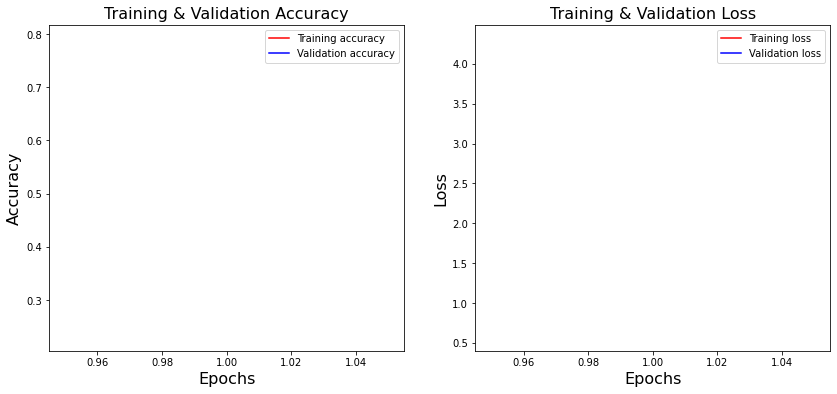

In [ ]:
# accuracy = history.history['accuracy'] #//
# val_accuracy = history.history['val_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']
# epochs = range(1, len(loss) + 1)


#Plotting Code:


import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'r', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'r', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

print(loss_values,val_loss_values,accuracy,val_accuracy,epochs)

In [ ]:
score = model.evaluate(test_data)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

3728/3728 [==============================] - 57s 15ms/step - loss: 4.3026 - accuracy: 0.2422
Test loss: 4.302584648132324
Test accuracy: 0.24222102761268616


In [ ]:
predict=model.predict(test_data)
# predict the class label
y_classes = predict.argmax(axis=-1)
y_classes

3728/3728 [==============================] - 55s 15ms/step


array([2, 2, 2, ..., 2, 2, 2])

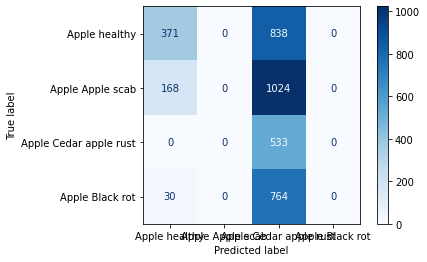

In [ ]:
confus_mtrx = confusion_matrix(test_data.classes, y_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=confus_mtrx, display_labels=labels_array)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
print(classification_report(test_data.classes, y_classes))# print

              precision    recall  f1-score   support

           0       0.65      0.31      0.42      1209
           1       0.00      0.00      0.00      1192
           2       0.17      1.00      0.29       533
           3       0.00      0.00      0.00       794

    accuracy                           0.24      3728
   macro avg       0.21      0.33      0.18      3728
weighted avg       0.24      0.24      0.18      3728



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**transfer learning**

In [ ]:
train_data2=datagen.flow_from_directory(dataset_dir,
                                       target_size=(64,64),
                                       batch_size=32,
                                       class_mode='categorical',
                                       shuffle=True,subset='training')

#create test set
test_data2=datagen.flow_from_directory(dataset_dir,
                                       target_size=(64,64),
                                       batch_size=1,
                                       shuffle=False,subset='validation')

Found 14920 images belonging to 4 classes.
Found 3728 images belonging to 4 classes.


Found 14920 images belonging to 4 classes.
Found 3728 images belonging to 4 classes.
Found 18648 files belonging to 4 classes.


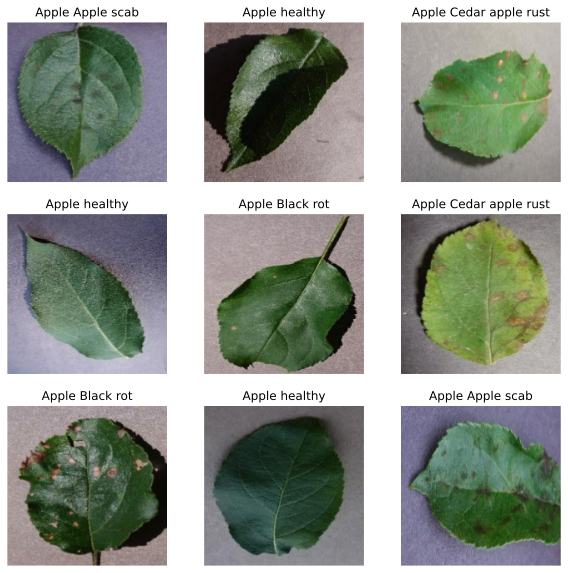

In [ ]:
import tensorflow 
from keras.models import Sequential 
from keras.layers import Dense,Flatten,Conv2D,MaxPooling2D, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory

from IPython import display 
display.set_matplotlib_formats('svg')

train_datagen = ImageDataGenerator(rescale=1./255,
                   fill_mode='nearest',
                   featurewise_center=True,
                   validation_split=0.2,
                   horizontal_flip=True,
                   shear_range=0.3,
                   zoom_range=0.25,
                   brightness_range=(0.4,0.7),
                   rotation_range=15,
                   featurewise_std_normalization=True,
                   )

train_generator= train_datagen.flow_from_directory(dataset_dir,
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  class_mode='binary',
                                                  subset='training')

test_generator = train_datagen.flow_from_directory(dataset_dir,
                                                 target_size=(224,224),
                                                 batch_size=32,
                                                 class_mode='binary',
                                                 subset='validation')

train_dataset = image_dataset_from_directory(dataset_dir,
                                             shuffle=True,
                                             batch_size=32,image_size=(224,224))
class_name =  train_dataset.class_names
plt.figure(figsize = (10,10))
for image , label in train_dataset.take(1):
    for i in range(9) :
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(class_name[label[i]])
        plt.axis("off")

In [ ]:
from keras.applications.vgg19 import VGG19
from keras.applications.mobilenet_v2 import MobileNetV2,preprocess_input
from tensorflow import keras

In [ ]:
vgg_model = VGG19(include_top=True,weights='imagenet')

for layer in vgg_model.layers:
    layer.trainable=False

In [ ]:
vgg_model = keras.Model(inputs=vgg_model.input,outputs=vgg_model.layers[-2].output)
model= keras.Sequential()

for layer in vgg_model.layers:
    model.add(layer)
    
model.add(Dense(128, activation='relu'))
model.add(Dense(4,activation='softmax'))

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
early = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

In [ ]:
FIT =model.fit(train_generator,
    validation_data = test_generator, 
    callbacks = [early],
    epochs = 1)

467/467 [==============================] - 12997s 28s/step - loss: 0.8274 - accuracy: 0.6448 - val_loss: 0.6298 - val_accuracy: 0.7479


In [ ]:
print(FIT.history.keys()) #records training metrics for each epoch.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


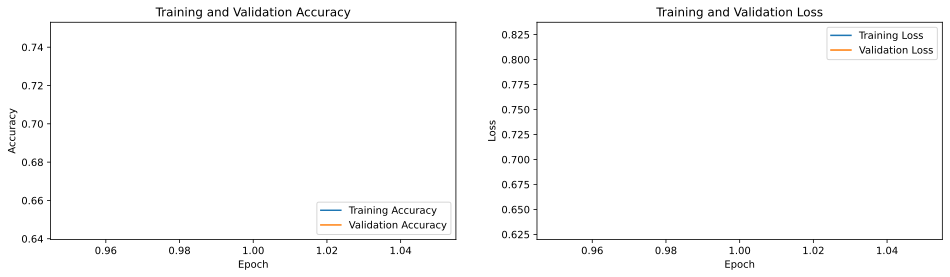

In [ ]:
acc = FIT.history['accuracy']
val_acc = FIT.history['val_accuracy']
loss = FIT.history['loss']
val_loss = FIT.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1) #training
plt.plot(epochs, acc, label='Training Accuracy') #blue plot
plt.plot(epochs, val_acc, label='Validation Accuracy') #orange plot 
plt.ylabel('Accuracy') #Y axis label
plt.xlabel('Epoch') #X axis label
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2) #Loss 
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.evaluate(test_generator)

117/117 [==============================] - 2576s 22s/step - loss: 0.6400 - accuracy: 0.7414


[0.6399867534637451, 0.741416335105896]

In [ ]:
predict=model.predict(test_generator)
# predict the class label
y_classes = predict.argmax(axis=-1)
y_classes

117/117 [==============================] - 2578s 22s/step


array([0, 3, 1, ..., 2, 3, 3])

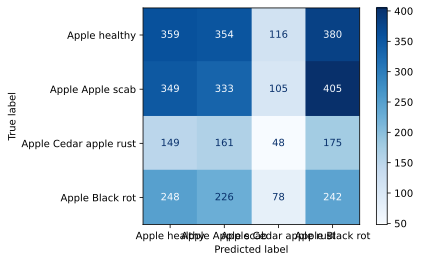

In [ ]:
cm = confusion_matrix(test_generator.classes, y_classes) #Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_array)


disp.plot(cmap=plt.cm.Blues)
plt.show();

In [ ]:
print(classification_report(test_generator.classes, y_classes)) #Accuracy, Recall, F1-Score


              precision    recall  f1-score   support

           0       0.32      0.30      0.31      1209
           1       0.31      0.28      0.29      1192
           2       0.14      0.09      0.11       533
           3       0.20      0.30      0.24       794

    accuracy                           0.26      3728
   macro avg       0.24      0.24      0.24      3728
weighted avg       0.27      0.26      0.26      3728

